In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import random

import helpers as hlp
import helpers.dataset.PlantVillage as pv
import helpers.features as feat

from pathlib import Path
from rembg import remove, new_session
import zipfile
import os
import time

C:\Users\fredc\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)

if pv_dataset is None:
    print("Invalid dataset")
else:
    pv_dataframe = pv_dataset.dataframe

print("PlantVillage", pv_dataframe.shape)
display( pv_dataframe.head() )

PlantVillage (60343, 5)


,species,disease,label,image_path,thumbnail_path
0,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
1,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
2,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
3,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...
4,Apple,Apple_scab,Apple_scab,Plant_leave_diseases_dataset_with_augmentation...,thumbnails/Plant_leave_diseases_dataset_with_a...


Etant donne que les features vont être utilisées tout au long de notre pipeline, nous processons tous le dataset une seul fois et mettons en cache les résultats. 

In [3]:
if not os.path.exists("dataset/Plant_leaf_diseases_dataset_with_augmentation"):
    with zipfile.ZipFile("dataset/Plant_leaf_diseases_dataset_with_augmentation.zip", 'r') as zip_ref:
        zip_ref.extractall("dataset/Plant_leaf_diseases_dataset_with_augmentation")
'''
session = new_session()

for root, dirs, files in os.walk('dataset/Plant_leaf_diseases_dataset_with_augmentation'):

    for file in Path(root).glob('*.JPG'):
        input_path = str(file)
        output_path = str(file.parent / (file.stem + ".out.png"))

        with open(input_path, 'rb') as i:
            with open(output_path, 'wb') as o:
                input = i.read()
                output = remove(input, session=session)
                o.write(output)
                time.sleep(0.2)
'''                
print(pv_dataset.get_image(60342))


[[[146 139 146]
  [144 137 144]
  [142 135 142]
  ...
  [150 145 151]
  [150 145 151]
  [151 146 152]]

 [[147 140 147]
  [144 137 144]
  [141 134 141]
  ...
  [147 142 148]
  [147 142 148]
  [148 143 149]]

 [[149 142 149]
  [146 139 146]
  [141 134 141]
  ...
  [145 140 146]
  [144 139 145]
  [144 139 145]]

 ...

 [[116 109 116]
  [100  93 100]
  [109 102 109]
  ...
  [138 133 139]
  [123 118 124]
  [108 103 109]]

 [[142 135 142]
  [123 116 123]
  [131 124 131]
  ...
  [126 121 127]
  [121 116 122]
  [125 120 126]]

 [[132 125 132]
  [113 106 113]
  [120 113 120]
  ...
  [127 122 128]
  [131 126 132]
  [117 112 118]]]


In [4]:
#
# features orb
#

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "orb_features" in locals():
    del orb_features

with hlp.Profile() as orb_loading:
    #
    # obtenir les orb features pour chaque image du dataset
    #
    orb_iter = feat.DatasetIter(pv_dataset, 
                                pv_dataframe["image_path"].iteritems(),
                                pv_dataframe.shape[0])

    # la premiere execution va mettre en cache les resultats
    orb_features = feat.load(configs.orb, orb_iter)

print(f"ORB loading:", orb_loading.round_duration(), "s")
print("ORB features", orb_features.features.shape)
print("ORB keypoints", orb_features.key_points.shape)

ORB loading: 0.0 s
ORB features (20906105, 32)
ORB keypoints (20906105, 7)


In [5]:
#
# features sift
#

# pour debugger, s'assurer que le fichier de features 
# est detruit a chaque execution de la cellule
if "sift_features" in locals():
    del sift_features

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe["image_path"].iteritems(),
                                 pv_dataframe.shape[0])

    # la premiere execution va mettre en cache les resultats
    sift_features = feat.load(configs.sift, sift_iter)

print(f"SIFT loading:", sift_loading.round_duration(), "s")
print("SIFT features", sift_features.features.shape)
print("SIFT keypoints", sift_features.key_points.shape)

SIFT loading: 0.01 s
SIFT features (14382049, 128)
SIFT keypoints (14382049, 7)


In [6]:
SAMPLES_GRID = (2, 4)
FIGSIZE = (10, SAMPLES_GRID[0] * 3.5)

def affiche_image(features, indices):
    dataset_iter = feat.DatasetIter(pv_dataset, 
                                    pv_dataframe.loc[indices, "image_path"].iteritems())

    _, axes = plt.subplots(SAMPLES_GRID[0], SAMPLES_GRID[1], figsize=FIGSIZE)
    for ax, \
       (image_index, \
        _, \
        key_points_count, \
        key_points_image) in zip(axes.flatten(), feat.key_points_iter(features, dataset_iter)):    
        if key_points_image is None:
            continue
        plt.sca(ax)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease, str(key_points_count)])

        plt.title(title)
        plt.axis("off")
        plt.imshow(key_points_image)

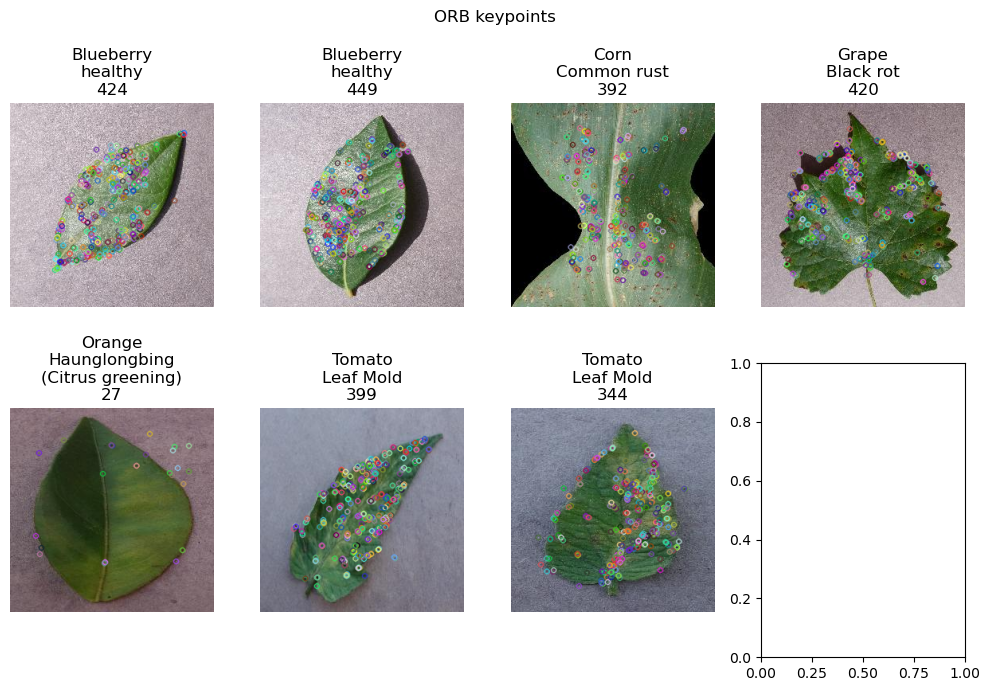

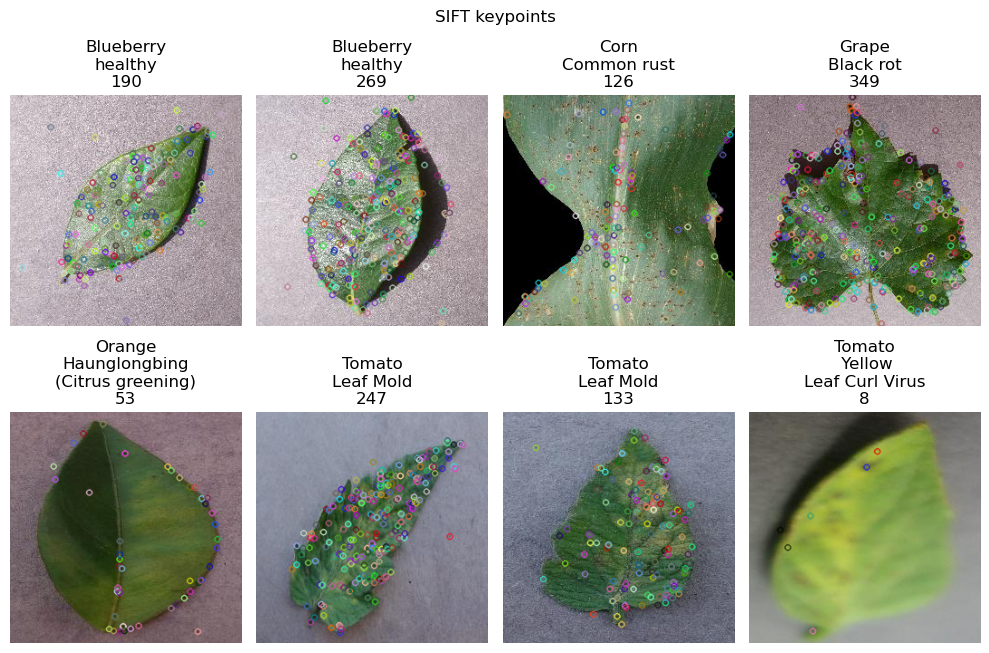

In [7]:
# selectionner quelques images aleatoirement
random.seed(55)
indices = random.sample(range(pv_dataframe.shape[0]), SAMPLES_GRID[0] * SAMPLES_GRID[1])
indices.sort()


#
# visualiser quelques orb keypoints
#
affiche_image(orb_features, indices)

plt.suptitle("ORB keypoints")
plt.tight_layout()
plt.show()


#
# visualiser quelques sift keypoints (les memes que orb)
#
affiche_image(sift_features, indices)

plt.suptitle("SIFT keypoints")
plt.tight_layout()
plt.show()